# Importing the required modules

In [1]:
# modules used for data handling and
# manipulation
import numpy as np
import pandas as pd

# modules used for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# modules used for encoding and data splitting
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import TargetEncoder, OrdinalEncoder, StandardScaler

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Reading the data

In [2]:
flight_df = pd.read_csv("DelayData.csv")

# Initial Data Exploration

In [3]:
flight_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1201664 entries, 0 to 1201663
Data columns (total 61 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   depdelay                 1201664 non-null  int64  
 1   arrdelay                 1198458 non-null  float64
 2   scheduleddepartdatetime  1201664 non-null  object 
 3   origin                   1201664 non-null  object 
 4   dest                     1201664 non-null  object 
 5   uniquecarrier            1201664 non-null  object 
 6   marketshareorigin        1201664 non-null  float64
 7   marketsharedest          1201664 non-null  float64
 8   hhiorigin                1201664 non-null  float64
 9   hhidest                  1201664 non-null  float64
 10  nonhubairportorigin      1201664 non-null  int64  
 11  smallhubairportorigin    1201664 non-null  int64  
 12  mediumhubairportorigin   1201664 non-null  int64  
 13  largehubairportorigin    1201664 non-null 

- The dataset has 1201664 rows and 61 columns.
- The dataset is partially pre-processed. Few of the categorical variables are already one-hot encoded.
- However, the many of categorical variables that are already encoded are ordinal in nature and one-hot encoding is not appropriate for it.
- It also appears that the `windspeed` column is transformed into `windspeedsquare`. It must checked which one is better and only one of them must be retained.
- The first five rows of the dataset are shown below.

In [4]:
flight_df.head()

,depdelay,arrdelay,scheduleddepartdatetime,origin,dest,uniquecarrier,marketshareorigin,marketsharedest,hhiorigin,hhidest,...,windgustdummy,windgustspeed,raindummy,raintracedummy,snowdummy,snowtracedummy,originmetropop,originmetrogdppercapita,destmetropop,destmetrogdppercapita
0,0,-4.0,08-Jan-2004 15:25:00,ELP,SAT,WN,0.618467,0.407567,0.417090,0.226878,...,0,0.0,0,0,0,0,702433,27314.633,1843927,35005.234
1,-4,11.0,22-Jan-2004 14:40:00,ATL,MSY,DL,0.500757,0.096321,0.319589,0.196657,...,0,0.0,0,0,0,0,4802300,49081.773,1314721,48848.234
2,3,12.0,29-Jan-2004 12:25:00,DFW,JFK,DL,0.060898,0.131962,0.296126,0.214357,...,0,0.0,0,0,0,0,5689982,50588.563,18747431,57295.402
3,-3,24.0,14-Jan-2004 15:55:00,SEA,EWR,CO,0.040522,0.347744,0.234712,0.249377,...,0,0.0,1,0,0,0,3163703,57755.547,18747431,57295.402
4,0,-8.0,14-Jan-2004 18:40:00,SLC,RNO,OO,0.506899,0.176493,0.341763,0.277364,...,0,0.0,0,0,0,0,1030597,45043.602,385049,49079.727


# Data Cleaning

## Handling null values

In [5]:
def display_cols_wt_na(df):
   print(df.isna().sum().loc[lambda x : x>0].sort_values(ascending = False)*100/len(df))

In [6]:
display_cols_wt_na(flight_df)

arrdelay           0.266797
temperature        0.038280
windspeed          0.038280
windspeedsquare    0.038280
windgustspeed      0.038280
dtype: float64


- The `arrdelay` has 0.26% null values. It is also the target column and hence the **rows** with null value for `arrdelay` must be dropped.
- After dropping those rows we will check if the other columns yet have null values.

In [7]:
flight_df = flight_df[flight_df['arrdelay'].notna()]
display_cols_wt_na(flight_df)

temperature        0.038383
windspeed          0.038383
windspeedsquare    0.038383
windgustspeed      0.038383
dtype: float64


- All the columns have 0.03% null values and hence can be imputed.
- Now, we will impute the missing values in the `temperature`, `windspeed`, `windspeedsquare`, and `windgustspeed` with the **mean** of the columns.
- `np.nanmean()` is used to compute mean of columns with null values.

In [8]:
to_impute_cols = ["temperature", "windspeed", "windspeedsquare", "windgustspeed"]

for col in to_impute_cols:
    col_mean = np.nanmean(flight_df[col])
    flight_df[col] = flight_df[col].fillna(col_mean)

In [9]:
display_cols_wt_na(flight_df)

Series([], dtype: float64)


All null values are handled.

## Dropping the columns

- There are few redundant columns and they need dropped.
- The `scheduleddepartdatetime` column stores the timestamp for each flight. However, the dataset also has all the individual components in separate columns and hence this column is dropped.
- The `originairportid` and `destairportid` columns have same information as the `origin` and `dest` columns. Hence, they are dropped.
- The `originstate` and `origincityname` columns have same information as `origin` column. While, this data is unknown for `dest`. Hence, those two columns are dropped.

**Note**: the time-series nature of data is not considered for the modelling.

In [10]:
cols_to_be_dropped = ["scheduleddepartdatetime",
                      "originairportid",
                      "destairportid",
                      "originstate",
                      "origincityname"]

flight_df = flight_df.drop(columns = cols_to_be_dropped,
                           axis = 1)

In [11]:
flight_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1198458 entries, 0 to 1201663
Data columns (total 56 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   depdelay                 1198458 non-null  int64  
 1   arrdelay                 1198458 non-null  float64
 2   origin                   1198458 non-null  object 
 3   dest                     1198458 non-null  object 
 4   uniquecarrier            1198458 non-null  object 
 5   marketshareorigin        1198458 non-null  float64
 6   marketsharedest          1198458 non-null  float64
 7   hhiorigin                1198458 non-null  float64
 8   hhidest                  1198458 non-null  float64
 9   nonhubairportorigin      1198458 non-null  int64  
 10  smallhubairportorigin    1198458 non-null  int64  
 11  mediumhubairportorigin   1198458 non-null  int64  
 12  largehubairportorigin    1198458 non-null  int64  
 13  nonhubairportdest        1198458 non-null  int6

# Rectifying incorrectly encoded ordinal categorical variables

As deduced from the initial analysis, there are few columns that are already one-hot encoded in the dataset. However, some of these categorical variables (described below) are ordinal and one-hot encoding is not appropriate for them.

- The columns of the form `temp_<lower-limit>_<upper-limit>` denote the range in which `temperature` falls in. These columns hold 1 if the `temperature` falls in that range and 0 otherwise. However, the ranges have an order associated with them as follows:

  $-\infty$ to $-10 < -10$ to $0 < 0$ to $10 < 10$ to $20 < 20$ to $30 < 30$ to $40 < 40$ to $\infty$

Hence, a single column `temp_range` is created and contains the categories. All the columns already present as a part of one-hot encoding are dropped.

- The columns of the form `<size of hub>airportorigin` and `<size of hub>airportdest` denote whether the origin and destination airports are hubs for some airline and if its a hub what is its size. These columns hold 1 if the `origin` or `dest` is a `<size of hub>` hub for some airline and 0 otherwise.

  nonhub $<$ small $<$ medium $<$ large

Hence, a two columns `hubairportorigin` and `hubairportdest` are created and contains the categories. All the columns already present as a part of one-hot encoding are dropped.

- The columns of the form `<size of hub>airlineorigin` and `<size of hub>airlinedest` denote whether the origin and destination airports are hubs for the airline and if its a hub what is its size. These columns hold 1 if the `origin` or `dest` is a `<size of hub>` hub for `uniquecarrier` and 0 otherwise.

  nonhub $<$ small $<$ medium $<$ large

Hence, a two columns `hubairlineorigin` and `hubairlinedest` are created and contains the categories. All the columns already present as a part of one-hot encoding are dropped.

In [12]:
# extracting all dummy features from the respective categories.
cols = list(flight_df.columns)
temperature_range = cols[37:44]
airport_connectivity_origin = cols[9:13]
airport_connectivity_dest = cols[13:17]
airline_connectivity_origin = cols[17:21]
airline_connectivity_dest = cols[21:25]

In [13]:
# converts dummy columns into a single categorical feature.
def onehot2ordinal(new_colname: str, dummies: list, str2replace: str, sep = None):

    flight_df[new_colname] = pd.from_dummies(flight_df[dummies], 
                           default_category = np.nan,
                           sep = sep)
    if not sep:
       flight_df[new_colname] = flight_df[new_colname].astype(str).apply(lambda x: x.replace(str2replace, 
                                                                                             ''))

    flight_df.drop(dummies, axis = 1, inplace = True)

In [14]:
# applies the function to all the respective kinds of dummy features.
arguments = [["temp_range", temperature_range, None, "_"],
             ["hubairportorigin", airport_connectivity_origin, "airportorigin", None],
             ["hubairportdest", airport_connectivity_dest, "airportdest", None],
             ["hubairlineorigin", airline_connectivity_origin, "airlineorigin", None],
             ["hubairlinedest", airline_connectivity_dest, "airlinedest", None]]

for new_colname, dummies, str2replace, sep in arguments:
    
    onehot2ordinal(new_colname = new_colname, dummies = dummies,
                   str2replace = str2replace, sep = sep)

It appears that `temp_range` has some null values and these can be derived by categorizing the temperature value for the particular row.

In [15]:
def categorise_temp(temp):
    if temp <= -10:
        return "ninfty_n10"
    elif temp > -10 and temp <= 0:
        return "n10_0"
    elif temp > 0 and temp <= 10:
        return "0_10"
    elif temp > 10 and temp <= 20:
        return "10_20"
    elif temp > 20 and temp <= 30:
        return "20_30"
    elif temp > 30 and temp <= 40:
        return "30_40"
    else:
        return "40_infty"

In [16]:
flight_df["temp_range"] = flight_df.apply(lambda x: categorise_temp(x.temperature),
                                           axis = 1)

In [17]:
flight_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1198458 entries, 0 to 1201663
Data columns (total 38 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   depdelay                 1198458 non-null  int64  
 1   arrdelay                 1198458 non-null  float64
 2   origin                   1198458 non-null  object 
 3   dest                     1198458 non-null  object 
 4   uniquecarrier            1198458 non-null  object 
 5   marketshareorigin        1198458 non-null  float64
 6   marketsharedest          1198458 non-null  float64
 7   hhiorigin                1198458 non-null  float64
 8   hhidest                  1198458 non-null  float64
 9   year                     1198458 non-null  int64  
 10  month                    1198458 non-null  int64  
 11  dayofmonth               1198458 non-null  int64  
 12  dayofweek                1198458 non-null  int64  
 13  scheduledhour            1198458 non-null  int6

# Binning the delays into categories

- The arrival and departure delay are binned into 5 categories.
- The arrival delay is the target variable and will be predicted using classification algorithms.

In [18]:
def bin_delay(delay):
    if delay <= 10:
        return "0-10"
    elif 10 < delay <= 20:
        return "10-20"
    elif 20 < delay <= 40:
        return "20-40"
    elif 40 < delay <= 60:
        return "40-60"
    elif delay > 60:
        return ">60"

In [19]:
flight_df["depdelay"] = flight_df.apply(lambda x: bin_delay(x.depdelay),
                                        axis = 1)
flight_df["arrdelay"] = flight_df.apply(lambda x: bin_delay(x.arrdelay),
                                        axis = 1)

# Splitting the data into train-test

In [20]:
target = "arrdelay"

In [21]:
# encoding the target variable
flight_df[target] = flight_df[target].replace(dict(zip(['0-10', '10-20', '20-40', '40-60', '>60'],
                                                       [i for i in range(5)])))

In [22]:
flight_y = flight_df.pop(target) 

In [23]:
flight_X_train, flight_X_test, flight_y_train, flight_y_test = train_test_split(flight_df, flight_y,
                                                                                 test_size = 0.2,
                                                                                 stratify = flight_y,
                                                                                 random_state = 42)

# Encoding the categorical variables

In [24]:
ord_cat_features = ["temp_range", "hubairportorigin", "hubairportdest", 
                    "hubairlinedest", "hubairlineorigin", "depdelay"]

hc_cat_features = ["origin", "dest", "uniquecarrier", "tailnum"]

cat_vars = ord_cat_features + hc_cat_features

## Ordinal variable encoding

In [25]:
categories = [
    ['ninfty_n10', 'n10_0', '0_10', '10_20', '20_30', '30_40', '40_infty'],
    ['nonhub', 'smallhub', 'mediumhub', 'largehub'],
    ['nonhub', 'smallhub', 'mediumhub', 'largehub'],
    ['nonhub', 'smallhub', 'mediumhub', 'largehub'],
    ['nonhub', 'smallhub', 'mediumhub', 'largehub'],
    ['0-10', '10-20', '20-40', '40-60', '>60']
]

oe = OrdinalEncoder(categories = categories).fit(flight_X_train[ord_cat_features])

flight_X_train[ord_cat_features] = oe.transform(flight_X_train[ord_cat_features])
flight_X_train[ord_cat_features] = flight_X_train[ord_cat_features].astype("int64")

flight_X_test[ord_cat_features] = oe.transform(flight_X_test[ord_cat_features])
flight_X_test[ord_cat_features] = flight_X_test[ord_cat_features].astype("int64")

## High Cardinality variable encoding

- The high cardinality variables in this context include `origin`, `dest`, `tailnum`, and `uniquecarrier`.
- It is so possible that an origin airport appears in the test data but does not appear in the train dataset.
- Therefore, all the categories must be passed as input to the `TargetEncoder()` to learn that these values are not in the train dataset.

In [26]:
categories = [list(set(flight_df[i]))for i in hc_cat_features]

In [27]:
for hc_col_idx in range(len(hc_cat_features)):
    hc_col = hc_cat_features[hc_col_idx]
    te = TargetEncoder(categories = [categories[hc_col_idx]])
    te = te.fit(flight_X_train[[hc_col]],
                y = flight_y_train)
    
    flight_X_train[hc_col] = te.transform(flight_X_train[[hc_col]])
    flight_X_test[hc_col] = te.transform(flight_X_test[[hc_col]])

In [28]:
flight_X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 958766 entries, 898074 to 382376
Data columns (total 37 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   depdelay                 958766 non-null  int64  
 1   origin                   958766 non-null  float64
 2   dest                     958766 non-null  float64
 3   uniquecarrier            958766 non-null  float64
 4   marketshareorigin        958766 non-null  float64
 5   marketsharedest          958766 non-null  float64
 6   hhiorigin                958766 non-null  float64
 7   hhidest                  958766 non-null  float64
 8   year                     958766 non-null  int64  
 9   month                    958766 non-null  int64  
 10  dayofmonth               958766 non-null  int64  
 11  dayofweek                958766 non-null  int64  
 12  scheduledhour            958766 non-null  int64  
 13  tailnum                  958766 non-null  float64
 14  capa

In [29]:
flight_X_train = flight_X_train[flight_X_train.columns]

# Scaling the numerical variables

In [30]:
float64_vars = flight_X_train.select_dtypes(include = ["float64"])
num_var = list(set(float64_vars).difference(hc_cat_features))

In [31]:
num_var

['temperature',
 'destmetrogdppercapita',
 'windspeed',
 'originmetrogdppercapita',
 'loadfactor',
 'marketsharedest',
 'windspeedsquare',
 'windgustspeed',
 'marketshareorigin',
 'numflights',
 'hhidest',
 'hhiorigin']

In [32]:
sscaler = StandardScaler().fit(flight_X_train[num_var])

scaled_train = sscaler.transform(flight_X_train[num_var])
flight_X_train[num_var] = scaled_train

scaled_test = sscaler.transform(flight_X_test[num_var])
flight_X_test[num_var] = scaled_test

# Correlation between the columns

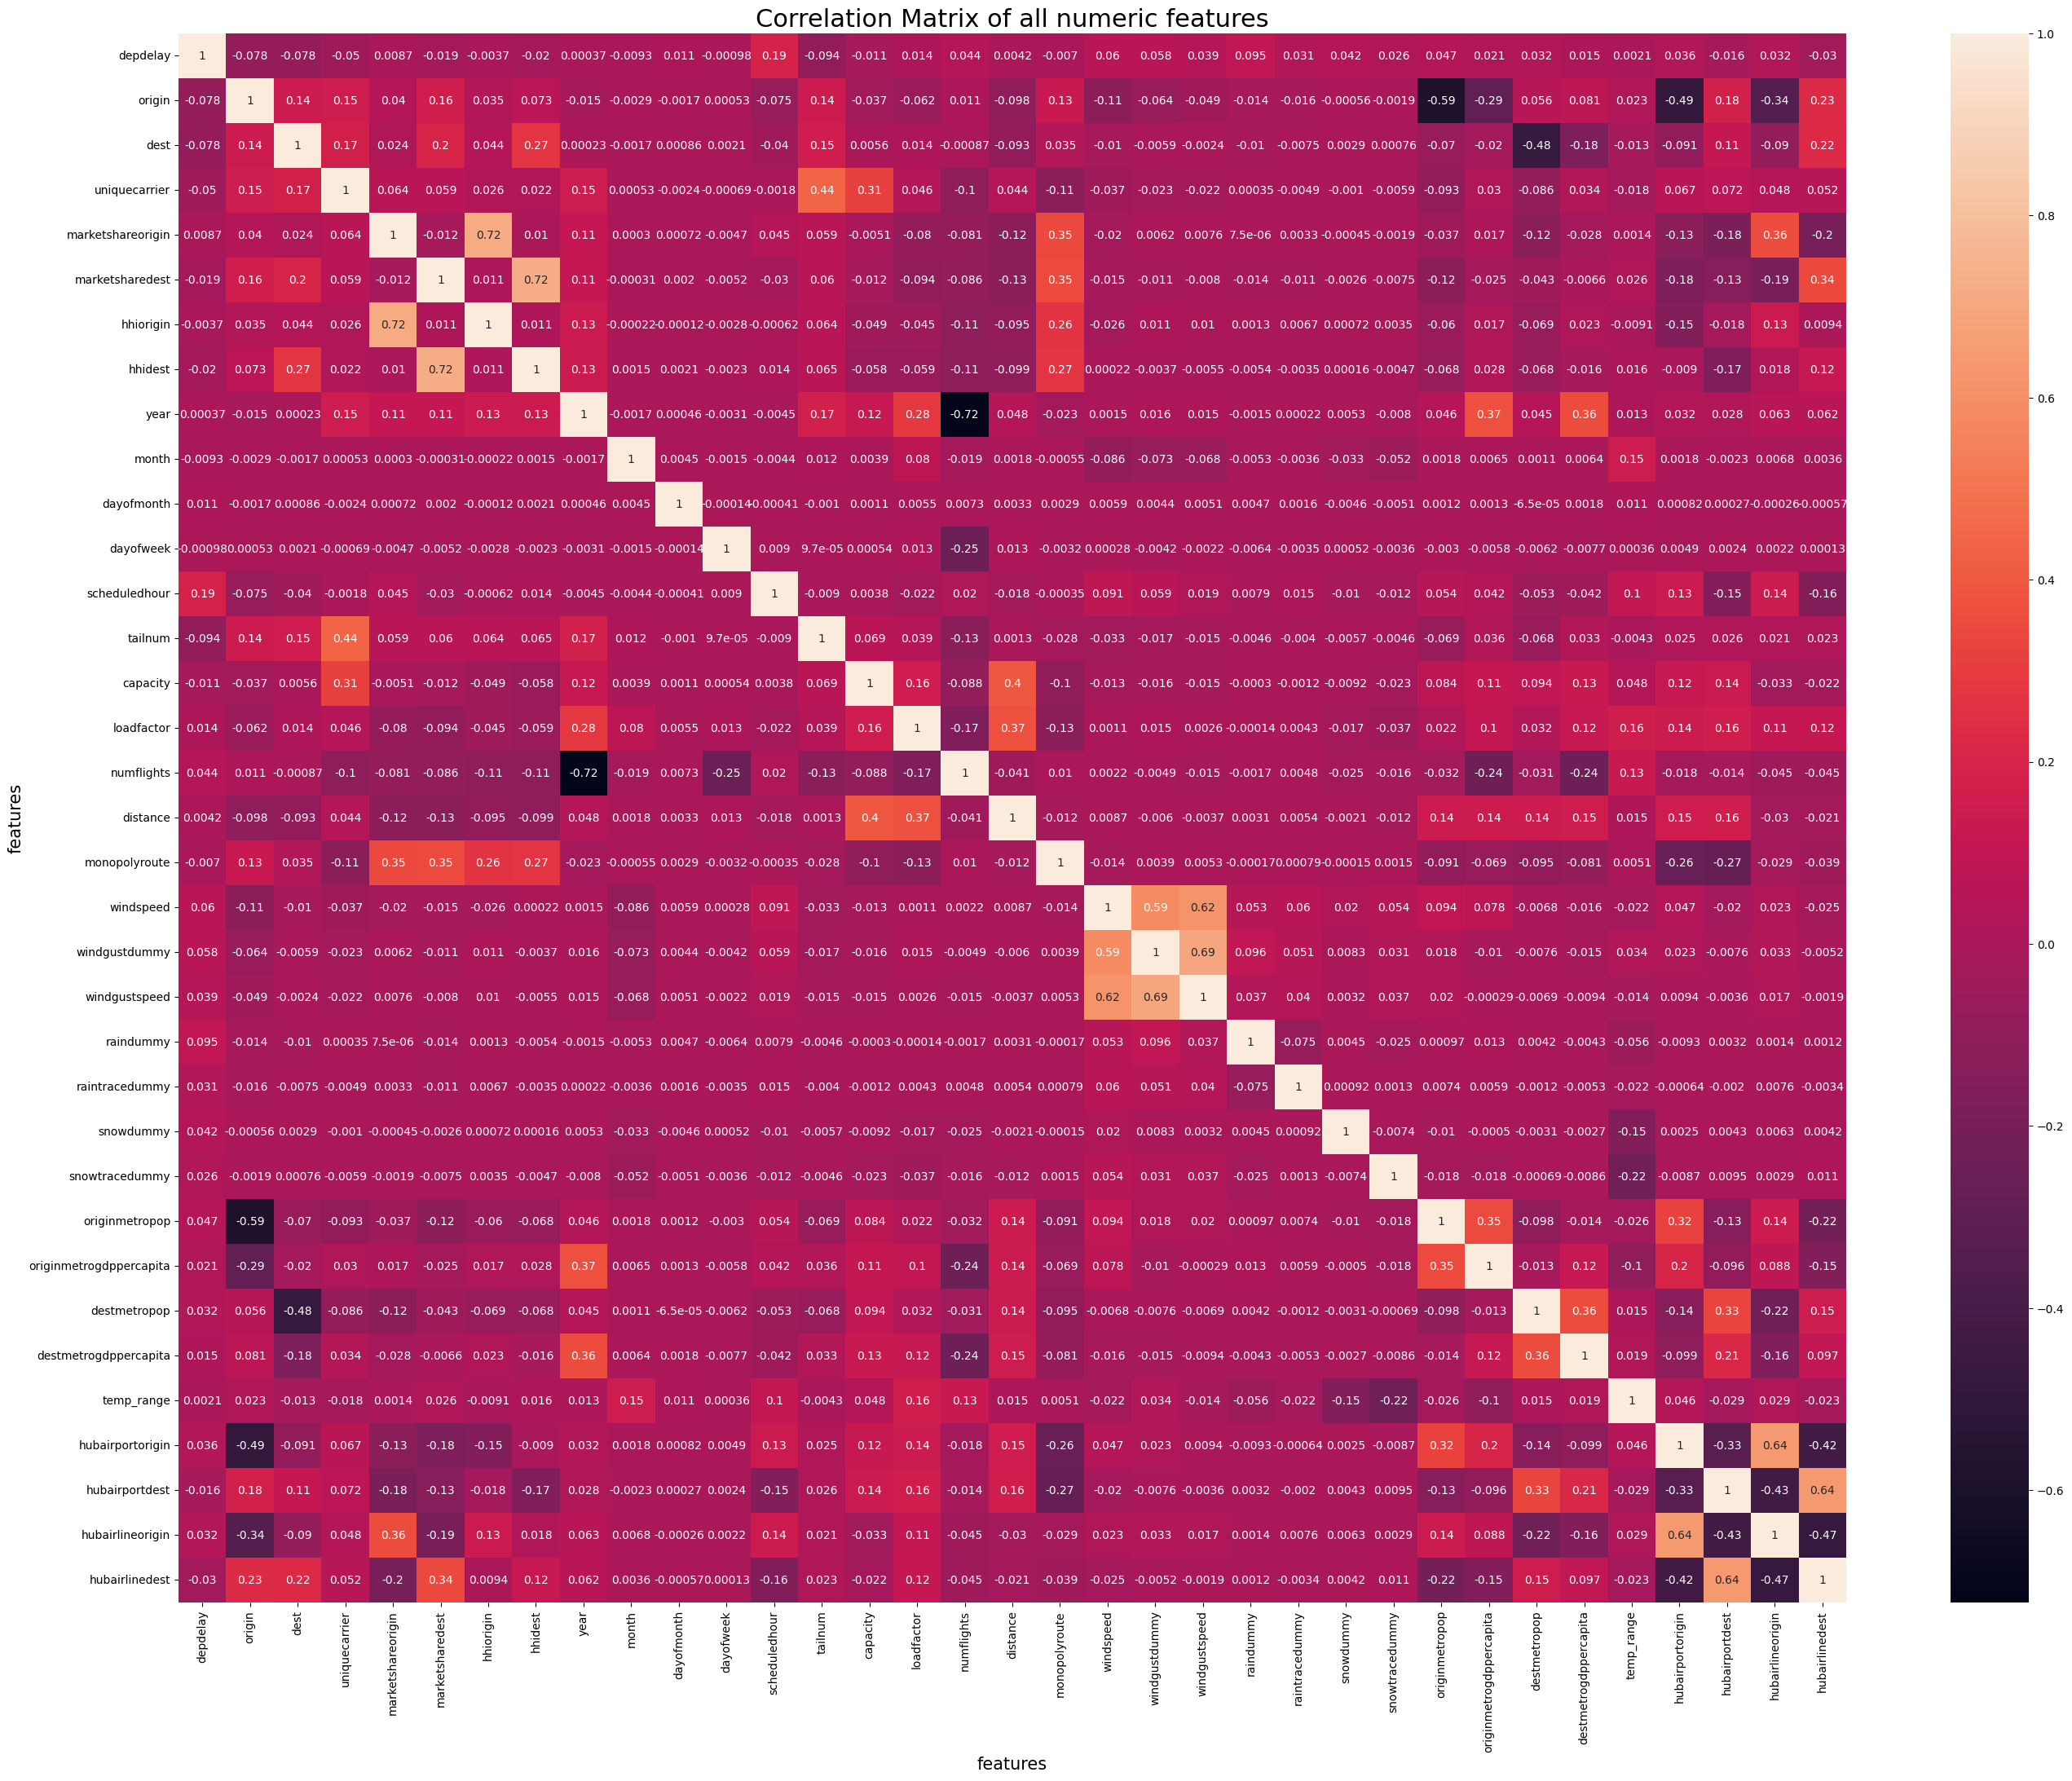

In [45]:
plt.figure(figsize = (33, 25))
sns.heatmap(flight_X_train.corr(), annot = True)
plt.xlabel("features", fontsize = 15)
plt.ylabel("features", fontsize = 15)
plt.title("Correlation Matrix of all numeric features", fontsize=22)
plt.show()

- The `depdelay` has slight positive correlation of 0.19 with `scheduledhour`. This makes sense because the air traffic at the `scheduledhour` decides whether the ATC gives permission for aircraft to depart.
- Moreover, there is very slight correlation with the columns pertaining to weather. This also makes sense since the weather (visibility) at departure decides whether the plane can take-off or not.
- There is positive correlation of 0.44 between `tailnum` and `uniquecarrier` since a particular aircraft is owned by a particular carrier. Hence, that correlation does make sense.
- All the weather columns have some relation with each other.
- The `temperature` and `temp_range` have a very high positive correlation of 0.96 and it does make sense as well. Therefore, one of the columns needs to be dropped.
- On similar lines, `windspeed` and `windspeedsquare` have very high positive correlation of 0.93 and hence one of them needs to be dropped.
- The `capacity` and `loadfactor` have a positive correlation of approximately 0.40 with the `distance`. This makes sense because long-haul routes generally have higher `capacity` and a higher payload resulting a higher `loadfactor`.
- Not all values in the matrix make sense. They arise as an artifact of the data but do not make sense at all.

In [35]:
flight_X_train = flight_X_train.drop(["windspeedsquare", "temperature"], axis = 1)
flight_X_test = flight_X_test.drop(["windspeedsquare", "temperature"], axis = 1)

- I dropped `windspeedsquare` since `windspeed` is more intuitive to understand and explain the models that will be trained later.
- The `temperature` column is dropped. This is because the target is a range of delay and keep the `temp_range` might help instead of actual value of temperature.